# Causal Model DoWhy

This model was run with demographic data as treatment. We realized in made little sense in terms of using it with our categorical target variable that is description. The visualization is nice to see how we want to setup our causal inference. However, it will not be investigated further as we decided to use Lift Causal Models that work better with categories.

# **Setup**

In [1]:
!apt install pip3
!pip3 install --upgrade numpy
!pip3 install causalml
!pip3 install dowhy
!pip3 install graphviz 
!pip3 install -q pydot
!apt install libgraphviz-dev
!pip3 install pygraphviz


Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package pip3
Requirement already up-to-date: numpy in /usr/local/lib/python3.7/dist-packages (1.20.2)
  Using cached https://files.pythonhosted.org/packages/d6/c6/58e517e8b1fb192725cfa23c01c2e60e4e6699314ee9684a1c5f5c9b27e1/numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.20.2
    Uninstalling numpy-1.20.2:
      Successfully uninstalled numpy-1.20.2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image, display
from dowhy import CausalModel
import graphviz
import pygraphviz
import warnings

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from google.colab import drive
drive.mount("/content/drive")

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/BPD_CRIME_DATA_WITHDEMOGRAPHICS.csv')
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Description', 'Inside/Outside', 'Weapon',
       'Post', 'District', 'Neighborhood', 'Longitude', 'Latitude', 'Premise',
       'Season', 'Month', 'Hour', 'Year', 'CSA', 'median_household_income',
       'households_below_poverty', 'perc18_24', 'perc25_64', 'perc65up',
       'perc_asian', 'perc_aa', 'perc_hisp', 'pwhi', 'num_households',
       'median_price_homes_sold'],
      dtype='object')

# **Cleaning**

In [5]:
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
df.head(5)

,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Premise,Season,Month,Hour,Year,CSA,median_household_income,households_below_poverty,perc18_24,perc25_64,perc65up,perc_asian,perc_aa,perc_hisp,pwhi,num_households,median_price_homes_sold
0,ROBBERY - RESIDENCE,Inside,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,ROW/TOWNHO,summer,9,23,2017,Brooklyn/Curtis Bay/Hawkins Point,40275.275330,24.213606,8.248062,57.449612,7.302326,2.527132,37.961240,14.906977,39.682171,NaN,52000.0
1,AUTO THEFT,Outside,NONE,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,STREET,summer,9,23,2017,Penn North/Reservoir Hill,34873.326816,25.964546,8.231621,56.940108,11.003879,0.624468,83.990917,2.876336,10.966033,NaN,127500.0
2,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,STREET,summer,9,22,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AGG. ASSAULT,Inside,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,ROW/TOWNHO,summer,9,22,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COMMON ASSAULT,Outside,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,STREET,summer,9,22,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df['yDescription'] = np.ravel(df['Description'].astype('category').cat.codes.astype('float'))
df['yDescription']

0         12.0
1          3.0
2         14.0
3          0.0
4          5.0
          ... 
263116     7.0
263117     7.0
263118     7.0
263119     4.0
263120     4.0
Name: yDescription, Length: 263121, dtype: float64

# **Is Below Average Poverty Treatment**

## Create model

In [9]:
df2 = df.copy()
df2['households_below_poverty'] = df2['households_below_poverty'].dropna()
df2.reset_index(inplace=True)

In [10]:
households_below_avg_poverty = df2['households_below_poverty'].mean()
households_below_avg_poverty

In [11]:
df2

,index,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Premise,Season,Month,Hour,Year,CSA,median_household_income,households_below_poverty,perc18_24,perc25_64,perc65up,perc_asian,perc_aa,perc_hisp,pwhi,num_households,median_price_homes_sold,yDescription
0,0,ROBBERY - RESIDENCE,Inside,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,ROW/TOWNHO,summer,9,23,2017,Brooklyn/Curtis Bay/Hawkins Point,40275.275330,24.213606,8.248062,57.449612,7.302326,2.527132,37.961240,14.906977,39.682171,NaN,52000.0,12.0
1,1,AUTO THEFT,Outside,NONE,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,STREET,summer,9,23,2017,Penn North/Reservoir Hill,34873.326816,25.964546,8.231621,56.940108,11.003879,0.624468,83.990917,2.876336,10.966033,NaN,127500.0,3.0
2,2,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,STREET,summer,9,22,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
3,3,AGG. ASSAULT,Inside,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,ROW/TOWNHO,summer,9,22,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,4,COMMON ASSAULT,Outside,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,STREET,summer,9,22,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263116,263116,LARCENY,Inside,NONE,832.0,SOUTHWESTERN,Violetville,-76.67195,39.26132,OTHER - IN,winter,1,0,2012,Morrell Park/Violetville,43529.596970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80700.0,7.0
263117,263117,LARCENY,Outside,NONE,444.0,NORTHEASTERN,Frankford,-76.53829,39.32493,OTHER - OU,winter,1,0,2012,Cedonia/Frankford,39556.115071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94500.0,7.0
263118,263118,LARCENY,Outside,NONE,321.0,EASTERN,CARE,-76.58497,39.29573,STREET,winter,1,0,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
263119,263119,BURGLARY,Inside,NONE,425.0,NORTHEASTERN,Glenham-Belhar,-76.54578,39.34701,APT. LOCKE,winter,1,0,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [12]:
df2['households_below_avg_poverty'] = np.where(df['households_below_poverty'] <= households_below_avg_poverty, True, False)

In [36]:
# Main causal parameters
outcome_name = 'yDescription'
treatment_name = 'households_below_avg_poverty'
# treatment_name = 'Functioning day bool'
common_causes_names = ['Weapon', 'District', 'Neighborhood', 'Premise', 'Season']

In [35]:
# Create model
model = CausalModel(data=df2,
                    treatment=treatment_name,
                    outcome=outcome_name,
                    common_causes=common_causes_names
                    )
model.interpret

<bound method CausalModel.interpret of <dowhy.causal_model.CausalModel object at 0x7f689cfcc850>>

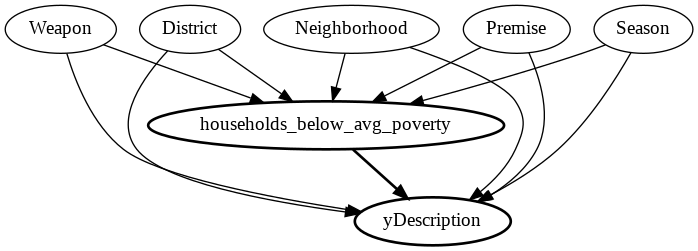

In [15]:
model.view_model()
display(Image(filename="causal_model.png"))

## Estimate Effect

In [16]:
# Identify effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print(estimate)
print("Causal Estimate is " + str(estimate.value))
identified_estimand.estimands

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
               d                                                              
───────────────────────────────(Expectation(yDescription|District,Season,Neigh
d[households_below_avg_poverty]                                               

                        
borhood,Premise,Weapon))
                        
Estimand assumption 1, Unconfoundedness: If U→{households_below_avg_poverty} and U→yDescription then P(yDescription|households_below_avg_poverty,District,Season,Neighborhood,Premise,Weapon,U) = P(yDescription|households_below_avg_poverty,District,Season,Neighborhood,Premise,Weapon)

## Realized estimand
b: yDescription~households_below_avg_poverty+District+Season+Neighborhood+Premise+Weapon
Target units: ate

## Estimate
Mean value: -0.1468322801108339

Causal Estimate is -0.1468322801108339


{'backdoor': {'assumptions': {'Unconfoundedness': 'If U→{households_below_avg_poverty} and U→yDescription then P(yDescription|households_below_avg_poverty,District,Season,Neighborhood,Premise,Weapon,U) = P(yDescription|households_below_avg_poverty,District,Season,Neighborhood,Premise,Weapon)'},
  'estimand': Derivative(Expectation(yDescription|District,Season,Neighborhood,Premise,Weapon), [households_below_avg_poverty])},
 'backdoor1': {'assumptions': {'Unconfoundedness': 'If U→{households_below_avg_poverty} and U→yDescription then P(yDescription|households_below_avg_poverty,District,Season,Neighborhood,Premise,Weapon,U) = P(yDescription|households_below_avg_poverty,District,Season,Neighborhood,Premise,Weapon)'},
  'estimand': Derivative(Expectation(yDescription|District,Season,Neighborhood,Premise,Weapon), [households_below_avg_poverty])},
 'frontdoor': None,
 'iv': None}

## Refute Estimate

In [17]:
# Common cause
res_refute=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_refute)

Refute: Add a Random Common Cause
Estimated effect:-0.1468322801108339
New effect:-0.1431482799358035

